# Import libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load data

In [50]:
df = pd.read_csv('df_model.csv', parse_dates=['Adjusted_Date'])

df_split = df[df['Adjusted_Date'] > '2023-05-01']
df_split.reset_index(drop=True, inplace=True)

# Split data into in-sample and out-of-sample sets
train_set = df_split[df_split['Adjusted_Date'] < '2025-08-01']
test_set = df_split[df_split['Adjusted_Date'] >= '2025-08-01']

# Separate features and target variable
X_train = train_set.drop(columns=['PSEI_Close'])
y_train = train_set['PSEI_Close']
X_test = test_set.drop(columns=['PSEI_Close'])
y_test = test_set['PSEI_Close']

# Define forecast error measure

In [51]:
# Define forecast error measure
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define variable set

In [52]:
# Sentiment columns sets (example)
column_sets = [
    ['negative_score_mean', 'neutral_score_mean', 'positive_score_mean'],
    ['negative_score_sd', 'neutral_score_sd', 'positive_score_sd'],
    ['negative_score_min', 'neutral_score_min', 'positive_score_min'],
    ['negative_score_max', 'neutral_score_max', 'positive_score_max']
]

# No neutral scores
column_sets_no_neutral = [
    ['negative_score_mean', 'positive_score_mean'],
    ['negative_score_sd', 'positive_score_sd'],
    ['negative_score_min', 'positive_score_min'],
    ['negative_score_max', 'positive_score_max']
]

# Linear regression

## Trend model

In [53]:
# Set up for linear regression modeling
results = []
results_coef = []

time_train = np.arange(len(y_train)).reshape(-1,1)
time_test = np.arange(len(y_test)).reshape(-1,1)

for cols in column_sets:
    key = 'reg_trend: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols].copy()
    X_train_cols['time_index'] = time_train
    X_test_cols = X_test[cols].copy()
    X_test_cols['time_index'] = time_test
    y_train_vals = y_train
    y_test_vals = y_test

    # Add constant
    X_train_const = sm.add_constant(X_train_cols)
    X_test_const = sm.add_constant(X_test_cols)

    # Fit model
    model = sm.OLS(y_train_vals, X_train_const).fit()

    # Predictions
    y_train_pred = model.predict(X_train_const)
    y_test_pred = model.predict(X_test_const)

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results.append({
        "model": key,
        "coef": model.params.to_dict(),
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# ----- Baseline model: intercept + time index -----
X_baseline_train = sm.add_constant(time_train)
X_baseline_test = sm.add_constant(time_test)

model_baseline = sm.OLS(y_train, X_baseline_train).fit()
y_train_pred_baseline = model_baseline.predict(X_baseline_train)
y_test_pred_baseline = model_baseline.predict(X_baseline_test)

results.append({
    "model": "reg: baseline_trend",
    "coef": model_baseline.params.to_dict(),
    "mse_train": mean_squared_error(y_train, y_train_pred_baseline),
    "rmse_train": root_mean_squared_error(y_train, y_train_pred_baseline),
    "mae_train": mean_absolute_error(y_train, y_train_pred_baseline),
    "mape_train": mean_absolute_percentage_error(y_train, y_train_pred_baseline),
    "mse_test": mean_squared_error(y_test, y_test_pred_baseline),
    "rmse_test": root_mean_squared_error(y_test, y_test_pred_baseline),
    "mae_test": mean_absolute_error(y_test, y_test_pred_baseline),
    "mape_test": mean_absolute_percentage_error(y_test, y_test_pred_baseline)
})


In [54]:
# Initialize results list
results_noneutral = []

for cols in column_sets_no_neutral:
    key = 'reg_trend: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols].copy()
    X_train_cols['time_index'] = time_train
    X_test_cols = X_test[cols].copy()
    X_test_cols['time_index'] = time_test
    y_train_vals = y_train
    y_test_vals = y_test

    # Add constant
    X_train_const = sm.add_constant(X_train_cols)
    X_test_const = sm.add_constant(X_test_cols)

    # Fit model
    model = sm.OLS(y_train_vals, X_train_const).fit()

    # Predictions
    y_train_pred = model.predict(X_train_const)
    y_test_pred = model.predict(X_test_const)

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results_noneutral.append({
        "model": key,
        "coef": model.params.to_dict(),
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# ----- Baseline model: intercept + time index -----
X_baseline_train = sm.add_constant(time_train)
X_baseline_test = sm.add_constant(time_test)

model_baseline = sm.OLS(y_train, X_baseline_train).fit()
y_train_pred_baseline = model_baseline.predict(X_baseline_train)
y_test_pred_baseline = model_baseline.predict(X_baseline_test)

results_noneutral.append({
    "model": "reg: baseline_trend",
    "coef": model_baseline.params.to_dict(),
    "mse_train": mean_squared_error(y_train, y_train_pred_baseline),
    "rmse_train": root_mean_squared_error(y_train, y_train_pred_baseline),
    "mae_train": mean_absolute_error(y_train, y_train_pred_baseline),
    "mape_train": mean_absolute_percentage_error(y_train, y_train_pred_baseline),
    "mse_test": mean_squared_error(y_test, y_test_pred_baseline),
    "rmse_test": root_mean_squared_error(y_test, y_test_pred_baseline),
    "mae_test": mean_absolute_error(y_test, y_test_pred_baseline),
    "mape_test": mean_absolute_percentage_error(y_test, y_test_pred_baseline)
})

## Non-trend

In [55]:
# Set up for linear regression modeling

for cols in column_sets:
    key = 'reg: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train
    y_test_vals = y_test

    # Add constant
    X_train_const = sm.add_constant(X_train_cols)
    X_test_const = sm.add_constant(X_test_cols)

    # Fit model
    model = sm.OLS(y_train_vals, X_train_const).fit()

    # Predictions
    y_train_pred = model.predict(X_train_const)
    y_test_pred = model.predict(X_test_const)

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results.append({
        "model": key,
        "coef": model.params.to_dict(),
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

In [56]:
# Initialize results list

for cols in column_sets_no_neutral:
    key = 'reg: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train
    y_test_vals = y_test

    # Add constant
    X_train_const = sm.add_constant(X_train_cols)
    X_test_const = sm.add_constant(X_test_cols)

    # Fit model
    model = sm.OLS(y_train_vals, X_train_const).fit()

    # Predictions
    y_train_pred = model.predict(X_train_const)
    y_test_pred = model.predict(X_test_const)

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results_noneutral.append({
        "model": key,
        "coef": model.params.to_dict(),
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# ARIMA

## Identify AR term

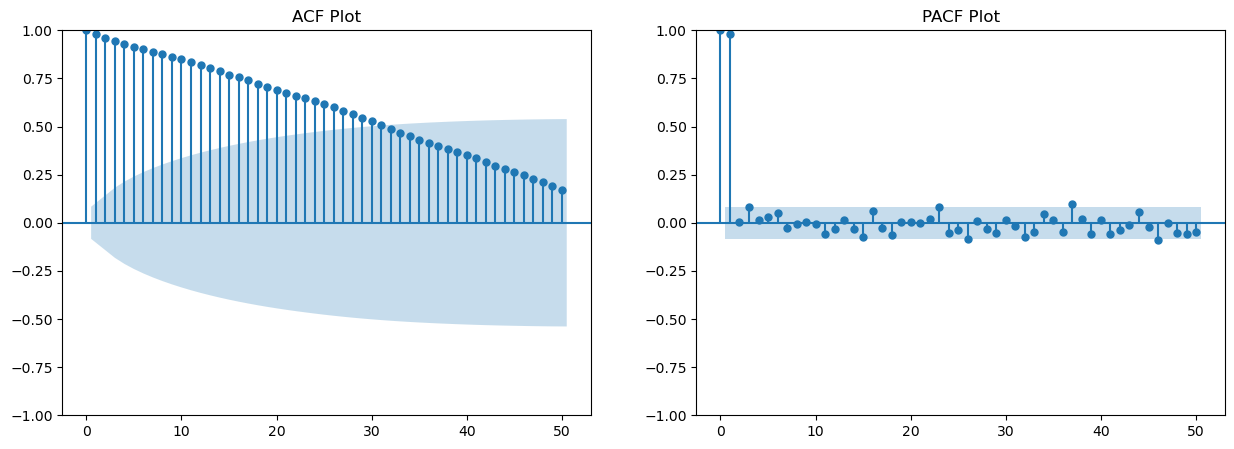

In [57]:
# Locate ideal AR term using ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF plot
plot_acf(y_train, lags=50, ax=axes[0])
axes[0].set_title('ACF Plot')

# PACF plot
plot_pacf(y_train, lags=50, ax=axes[1])
axes[1].set_title('PACF Plot')

plt.show()

## Idenitfy differencing term

In [58]:
result_adf = adfuller(df['PSEI_Close'])
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])

ADF Statistic: -2.84475892902403
p-value: 0.052159224685149705


In [59]:
df['PSEI_diff1'] = df['PSEI_Close'].diff().dropna()
result_adf2 = adfuller(df['PSEI_diff1'].dropna())
print('ADF Statistic after 1st difference:', result_adf2[0])
print('p-value:', result_adf2[1])


ADF Statistic after 1st difference: -25.01663206472803
p-value: 0.0


## Modeling ARIMA (2,1,1)

In [60]:
# ARIMA order
arima_order = (2,1,1)   

for cols in column_sets:
    key = 'ARIMA: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train
    y_test_vals = y_test

    # Fit model
    model_arima = ARIMA(endog=y_train_vals, exog=X_train_cols, order=arima_order)
    model = model_arima.fit()

    # Predictions
    y_train_pred = model.predict(start=0, end=len(y_train_vals)-1, exog=X_train_cols)
    y_test_pred = model.get_forecast(steps=len(y_test_vals), exog=X_test_cols).predicted_mean

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results.append({
        "model": key,
        "coef": model.params,
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# ----- ARIMA Baseline model -----
model_baseline = ARIMA(endog=y_train, order=arima_order).fit()
y_train_pred_baseline = model_baseline.predict(start=0, end=len(y_train)-1)
y_test_pred_baseline = model_baseline.get_forecast(steps=len(y_test)).predicted_mean

results.append({
    "model": "ARIMA: base",
    "coef": model_baseline.params,
    "mse_train": mean_squared_error(y_train, y_train_pred_baseline),
    "rmse_train": root_mean_squared_error(y_train, y_train_pred_baseline),
    "mae_train": mean_absolute_error(y_train, y_train_pred_baseline),
    "mape_train": mean_absolute_percentage_error(y_train, y_train_pred_baseline),
    "mse_test": mean_squared_error(y_test, y_test_pred_baseline),
    "rmse_test": root_mean_squared_error(y_test, y_test_pred_baseline),
    "mae_test": mean_absolute_error(y_test, y_test_pred_baseline),
    "mape_test": mean_absolute_percentage_error(y_test, y_test_pred_baseline)
})

In [61]:
# ARIMA order
arima_order = (2,1,1)   

for cols in column_sets_no_neutral:
    key = 'ARIMA: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train
    y_test_vals = y_test

    # Fit model
    model_arima = ARIMA(endog=y_train_vals, exog=X_train_cols, order=arima_order)
    model = model_arima.fit()

    # Predictions
    y_train_pred = model.predict(start=0, end=len(y_train_vals)-1, exog=X_train_cols)
    y_test_pred = model.get_forecast(steps=len(y_test_vals), exog=X_test_cols).predicted_mean

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results_noneutral.append({
        "model": key,
        "coef": model.params,
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# ----- ARIMA Baseline model -----
model_baseline = ARIMA(endog=y_train, order=arima_order).fit()
y_train_pred_baseline = model_baseline.predict(start=0, end=len(y_train)-1)
y_test_pred_baseline = model_baseline.get_forecast(steps=len(y_test)).predicted_mean

results_noneutral.append({
    "model": "ARIMA: base",
    "coef": model_baseline.params,
    "mse_train": mean_squared_error(y_train, y_train_pred_baseline),
    "rmse_train": root_mean_squared_error(y_train, y_train_pred_baseline),
    "mae_train": mean_absolute_error(y_train, y_train_pred_baseline),
    "mape_train": mean_absolute_percentage_error(y_train, y_train_pred_baseline),
    "mse_test": mean_squared_error(y_test, y_test_pred_baseline),
    "rmse_test": root_mean_squared_error(y_test, y_test_pred_baseline),
    "mae_test": mean_absolute_error(y_test, y_test_pred_baseline),
    "mape_test": mean_absolute_percentage_error(y_test, y_test_pred_baseline)
})

# LSTM

In [62]:
# Develop LSTM models
for cols in column_sets:
    key = 'LSTM: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train.values
    y_test_vals = y_test.values

    # Reshape input to be 3D [samples, timesteps, features]
    X_train_reshaped = X_train_cols.values.reshape((X_train_cols.shape[0], X_train_cols.shape[1], 1))
    X_test_reshaped = X_test_cols.values.reshape((X_test_cols.shape[0], X_test_cols.shape[1], 1))

    # Fit model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_cols.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_reshaped, y_train_vals, epochs=50, batch_size=32, verbose=0)

    # Predictions - flatten to 1D
    y_train_pred = model.predict(X_train_reshaped, verbose=0).flatten()
    y_test_pred = model.predict(X_test_reshaped, verbose=0).flatten()

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results.append({
        "model": key,
        "coef": None,
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display results
display(results_df)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

,model,coef,mse_train,rmse_train,mae_train,mape_train,mse_test,rmse_test,mae_test,mape_test
0,"reg_trend: negative_score_mean, neutral_score_...","{'const': 2824130649.381898, 'negative_score_m...",1.046000e+05,323.419174,247.660065,3.753033,174428.433542,417.646302,399.677162,6.547459
1,"reg_trend: negative_score_sd, neutral_score_sd...","{'const': 6185.134307928713, 'negative_score_s...",1.048206e+05,323.760041,247.053487,3.743978,171835.193351,414.530087,397.202843,6.506979
2,"reg_trend: negative_score_min, neutral_score_m...","{'const': 6484.504047492792, 'negative_score_m...",1.047408e+05,323.636861,246.811935,3.741442,165412.513027,406.709372,389.108685,6.374837
3,"reg_trend: negative_score_max, neutral_score_m...","{'const': 8231.368442039793, 'negative_score_m...",1.050372e+05,324.094492,248.601360,3.768284,172435.531545,415.253575,397.013802,6.504373
4,reg: baseline_trend,"{'const': 6539.896527845633, 'x1': -0.02861684...",1.054969e+05,324.802835,249.166720,3.776836,172257.245397,415.038848,397.637661,6.514617
5,"reg: negative_score_mean, neutral_score_mean, ...","{'const': 2814172049.9209595, 'negative_score_...",1.046130e+05,323.439386,248.084677,3.759884,170139.556011,412.479764,394.159645,6.457694
6,"reg: negative_score_sd, neutral_score_sd, posi...","{'const': 6180.355322812974, 'negative_score_s...",1.048297e+05,323.774119,247.432520,3.750073,168287.081941,410.228085,392.618377,6.432392
7,"reg: negative_score_min, neutral_score_min, po...","{'const': 6475.678852367572, 'negative_score_m...",1.047698e+05,323.681698,247.515238,3.752728,159195.598738,398.993231,380.885418,6.241054
8,"reg: negative_score_max, neutral_score_max, po...","{'const': 8172.301477432576, 'negative_score_m...",1.050655e+05,324.138111,249.167818,3.777461,166208.080276,407.686252,388.929145,6.372854
9,"ARIMA: negative_score_mean, neutral_score_mean...",negative_score_mean 1.839666e+07 neutral_sc...,6.137783e+11,783440.042233,33425.234958,500.943971,26585.905621,163.051849,140.639885,2.313937


In [63]:
# Develop LSTM models
for cols in column_sets_no_neutral:
    key = 'LSTM: ' + ', '.join(cols)

    # Prepare X and y
    X_train_cols = X_train[cols]
    X_test_cols = X_test[cols]
    y_train_vals = y_train.values
    y_test_vals = y_test.values

    # Reshape input to be 3D [samples, timesteps, features]
    X_train_reshaped = X_train_cols.values.reshape((X_train_cols.shape[0], X_train_cols.shape[1], 1))
    X_test_reshaped = X_test_cols.values.reshape((X_test_cols.shape[0], X_test_cols.shape[1], 1))

    # Fit model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train_cols.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_reshaped, y_train_vals, epochs=50, batch_size=32, verbose=0)

    # Predictions - flatten to 1D
    y_train_pred = model.predict(X_train_reshaped, verbose=0).flatten()
    y_test_pred = model.predict(X_test_reshaped, verbose=0).flatten()

    # Compute error metrics for train
    mse_train = mean_squared_error(y_train_vals, y_train_pred)
    rmse_train = root_mean_squared_error(y_train_vals, y_train_pred)
    mae_train = mean_absolute_error(y_train_vals, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_vals, y_train_pred)

    # Compute error metrics for test
    mse_test = mean_squared_error(y_test_vals, y_test_pred)
    rmse_test = root_mean_squared_error(y_test_vals, y_test_pred)
    mae_test = mean_absolute_error(y_test_vals, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_vals, y_test_pred)

    # Append results
    results_noneutral.append({
        "model": key,
        "coef": None,
        "mse_train": mse_train,
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test
    })

# Convert to DataFrame
results_df_noneutral = pd.DataFrame(results_noneutral)

# Display results
display(results_df_noneutral)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim`

,model,coef,mse_train,rmse_train,mae_train,mape_train,mse_test,rmse_test,mae_test,mape_test
0,"reg_trend: negative_score_mean, positive_score...","{'const': 6513.821054948467, 'negative_score_m...",1.050690e+05,324.143547,248.010699,3.758709,1.734033e+05,416.417233,398.773263,6.532883
1,"reg_trend: negative_score_sd, positive_score_sd","{'const': 6298.639634570497, 'negative_score_s...",1.049041e+05,323.889035,246.870852,3.741442,1.740200e+05,417.157070,399.855933,6.550337
2,"reg_trend: negative_score_min, positive_score_min","{'const': 6501.9959414024825, 'negative_score_...",1.048758e+05,323.845318,247.127887,3.746176,1.654928e+05,406.808051,389.632469,6.383252
3,"reg_trend: negative_score_max, positive_score_max","{'const': 7507.695844288213, 'negative_score_m...",1.054002e+05,324.654003,249.648545,3.784332,1.714624e+05,414.080233,396.709421,6.499360
4,reg: baseline_trend,"{'const': 6539.896527845633, 'x1': -0.02861684...",1.054969e+05,324.802835,249.166720,3.776836,1.722572e+05,415.038848,397.637661,6.514617
5,"reg: negative_score_mean, positive_score_mean","{'const': 6507.925378567515, 'negative_score_m...",1.050790e+05,324.158941,248.432202,3.765463,1.696646e+05,411.903619,393.954500,6.454485
6,"reg: negative_score_sd, positive_score_sd","{'const': 6293.249341741463, 'negative_score_s...",1.049116e+05,323.900595,247.249977,3.747511,1.707600e+05,413.231131,395.674136,6.482300
7,"reg: negative_score_min, positive_score_min","{'const': 6493.708690098705, 'negative_score_m...",1.048992e+05,323.881521,247.707122,3.755512,1.598843e+05,399.855404,382.222287,6.262700
8,"reg: negative_score_max, positive_score_max","{'const': 7445.747883377163, 'negative_score_m...",1.054299e+05,324.699721,250.215456,3.793517,1.650867e+05,406.308567,388.424607,6.364585
9,"ARIMA: negative_score_mean, positive_score_mean",negative_score_mean -2.647701 positive_sc...,8.475107e+04,291.120370,61.374183,0.937444,3.061444e+04,174.969813,149.189585,2.456816


# Export results

In [64]:
# Export results
results_df.to_csv('modeling_results_aCOVID.csv', index=False)
results_df_noneutral.to_csv('modeling_results_noneutral_aCOVID.csv', index=False)